# Advanced Plotting

**BEFORE BEGINNING THIS EXERCISE** -  Check that your kernel (upper right corner, above) is `NPL 2023b`. This should be the default kernel, but if it is not, click on that button and select `NPL 2023b`.

_______________

## Exercise 1: CAM-SE output analysis

Examples of simple analysis and plotting that can be done with CAM-SE output on the native cubed-sphere grid.

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def make_map(data, lon, lat,):
    """This function plots data on a Mollweide projection map. 
    
    The data is transformed to the projection using Cartopy's `transform_points` method.

    The plot is made by triangulation of the points, producing output very similar to `pcolormesh`,
    but with triangles instead of rectangles used to make the image.
    """
    dataproj = ccrs.PlateCarree() # assumes data is lat/lon
    plotproj = ccrs.Mollweide()   # output projection 
    # set up figure / axes object, set to be global, add coastlines
    fig, ax = plt.subplots(figsize=(6,3), subplot_kw={'projection':plotproj})
    ax.set_global()
    ax.coastlines(linewidth=0.2)
    # this figures out the transformation between (lon,lat) and the specified projection
    tcoords = plotproj.transform_points(dataproj, lon.values, lat.values) # working with the projection
    xi=tcoords[:,0] != np.inf  # there can be bad points set to infinity, but we'll ignore them
    # print(f"{xi.shape = } --- Number of False: {np.count_nonzero(~xi)}")
    assert xi.shape[0] == tcoords.shape[0], f"Something wrong with shapes should be the same: {xi.shape = }, {tcoords.shape = }"
    tc=tcoords[xi,:]
    datai=data.values[xi]  # convert to numpy array, then subset
    # Use tripcolor --> triangluates the data to make the plot
    # rasterized=True reduces the file size (necessary for high-resolution for reasonable file size)
    # keep output as "img" to make specifying colorbar easy
    img = ax.tripcolor(tc[:,0],tc[:,1], datai, shading='gouraud', rasterized=True)
    cbar = fig.colorbar(img, ax=ax, shrink=0.4)
    return fig, ax

## Input data

In the following cell, specify the data source.

`location_of_hfiles` is a path object that points to the directory where data files should be.
`search_pattern` specifies what pattern to look for inside that directory.

**SIMPLIFICATION** If you want to just provide a path to a file, simply specify it by commenting (with `#`) the lines above "# WE need lat and lon", and replace with:
```
fils = "/path/to/your/data/file.nc"
```

## Parameters
Specify the name of the variable to be analyzed with `variable_name`.

To change the units of the variable, specify `scale_factor` and provide the new units string as `units`. Otherwise, just set `scale_factor` and `units`:

```
scale_factor = 1
units = ds["variable_name"].attrs["units"]
```

In [3]:
location_of_hfiles = Path("/glade/scratch/hannay/archive/f.cam6_3_112.FMTHIST_v0c.ne30.non-ogw-ubcT-effgw0.7_taubgnd2.5.001/atm/hist/")
search_pattern = "f.cam6_3_112.FMTHIST_v0c.ne30.non-ogw-ubcT-effgw0.7_taubgnd2.5.001.cam.h3.2003-01-01-00000.nc"

fils = sorted(location_of_hfiles.glob(search_pattern))
if len(fils) == 1:
    ds = xr.open_dataset(fils[0])
else:
    print(f"Just so you konw, there are {len(fils)} files about to be loaded.")
    ds = xr.open_mfdataset(fils)

# We need lat and lon:
lat = ds['lat']
lon = ds['lon']

# Choose what variables to plot,
# in this example we are going to combine the
# convective and stratiform precipitation into
# a single, total precipitation variable
convective_precip_name = "PRECC"
stratiform_precip_name = "PRECL"

# If needed, select scale factor and new units:
scale_factor = 86400. * 1000. # m/s -> mm/day
units = "mm/day"

cp_data = scale_factor * ds[convective_precip_name]
st_data = scale_factor * ds[stratiform_precip_name]
cp_data.attrs['units'] = units
st_data.attrs['units'] = units

# Sum the two precip variables to get total precip
data = cp_data + st_data
data

<xarray.DataArray (time: 40, ncol: 48600)>
array([[9.5841005e-02, 6.2679447e-02, 7.8599140e-02, ..., 2.3464201e-02,
        3.8250297e-02, 1.6159904e-01],
       [7.3920704e-02, 1.9015890e-02, 2.6577042e-02, ..., 1.4940535e-02,
        8.4523354e-03, 1.3440083e-02],
       [7.2282478e-02, 4.7977455e-03, 2.5292812e-03, ..., 3.4423193e-03,
        2.7449809e-03, 8.0430694e-03],
       ...,
       [5.7706954e-03, 2.4036758e-02, 8.1473455e-04, ..., 4.3803058e+00,
        1.0612594e+00, 1.8941417e-02],
       [1.8871019e-03, 8.1471270e-03, 2.5718901e-04, ..., 2.7412231e+00,
        6.1731112e-01, 5.2671223e-03],
       [1.0812210e-03, 1.4244054e-03, 1.8905780e-03, ..., 2.7519507e+00,
        8.6638373e-01, 1.5805304e-02]], dtype=float32)
Coordinates:
  * time     (time) object 2003-01-01 00:00:00 ... 2003-01-05 21:00:00
Dimensions without coordinates: ncol

In [4]:
# temporal averaging
# simplest case, just average over time:
data_avg = data.mean(dim='time')
data_avg

<xarray.DataArray (ncol: 48600)>
array([0.22318001, 0.23549728, 0.25513405, ..., 2.0062578 , 1.6447967 ,
       1.007323  ], dtype=float32)
Dimensions without coordinates: ncol

In [5]:
#
# Global average
#
data_global_average = data_avg.weighted(ds['area']).mean()
print(f"The area-weighted average of the time-mean data is: {data_global_average.item()}")

The area-weighted average of the time-mean data is: 2.962286870373966


In [6]:
#
# Regional average using a (logical) rectangle
#
west_lon = 110.0
east_lon = 200.0
south_lat = -30.0
north_lat = 30.0

# To reduce to the region, we need to know which indices of ncol dimension are inside the boundary

region_inds = np.argwhere(((lat > south_lat)&(lat < north_lat)&(lon>west_lon)&(lon<east_lon)).values)
print(f"The number of grid columns inside the specified region is {region_inds.shape[0]}")

# get the area associated with each selected column. Note the region_inds array needs to be flattened to use in isel.
region_area = ds['area'].isel(ncol=region_inds.flatten()) 
# get the data in the region:
region_data = data_avg.isel(ncol=region_inds.flatten())

data_region_average = region_data.weighted(region_area).mean()
print(f"The area-weighted average in thee region [{west_lon}E-{east_lon}E, {south_lat}-{north_lat}] is: {data_region_average.item()}")

The number of grid columns inside the specified region is 5912
The area-weighted average in thee region [110.0E-200.0E, -30.0-30.0] is: 5.053126392307857


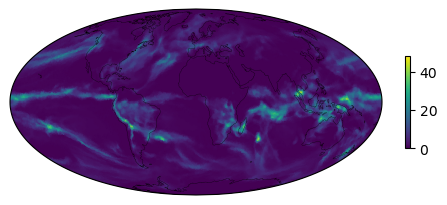

In [7]:
# plot the map of the time average 
# using the function defined above.
fig1, ax1 = make_map(data_avg, lon, lat,)

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

![plot example](../../../images/diagnostics/cam/advanced_plot_1.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>